# Extraction

In [34]:
from datasets import load_dataset
from pathlib import Path
import json
import random
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image as PILImage
from IPython.display import display
from openai import AsyncOpenAI

# Import from src modules
from src import (
    convert_docs_to_pdf,
    process_pdfs_with_mineru,
    extract_tables_from_output,
    merge_consecutive_tables,
    find_summary_compensation_in_doc,
    extract_all_summary_compensation,
    save_classification_results,
    save_extraction_results,
    display_all_results,
    display_table_preview,
    TableType
)

# Setup directories
Path("pdfs").mkdir(exist_ok=True)
Path("output").mkdir(exist_ok=True)

# Base path
BASE_PATH = Path("/home/pdipasquale/MIIA/stuff")

# Load dataset and sample random docs
dataset = load_dataset("json", data_files="/home/pdipasquale/MIIA/stuff/data/DEF14A_all.jsonl")
all_docs = dataset["train"]

random.seed(35236236)
indices = random.sample(range(len(all_docs)), 100)
docs = all_docs.select(indices)
# Setup VLM client
client = AsyncOpenAI(base_url="http://localhost:8000/v1", api_key="dummy")
MODEL = "Qwen/Qwen3-VL-32B-Instruct"


In [ ]:
convert_docs_to_pdf(docs)
failed, success = process_pdfs_with_mineru(max_concurrent=16)
all_tables, extraction_stats = extract_tables_from_output()

with open("all_tables.json") as f:
    all_tables = json.load(f)

100%|██████████| 100/100 [01:48<00:00,  1.09s/it]


Found 250 PDFs total
  - Already processed (skipped): 150
  - To process: 100

Processing 100 PDFs (max 16 concurrent)


  0%|          | 0/100 [00:00<?, ?it/s]

# Classify

In [ ]:
n = 107
doc_sources = list(set(t.get('source_doc') for t in all_tables))

source_doc = doc_sources[n]
metadata_path = BASE_PATH / "output" / source_doc / "metadata.json"

with open(metadata_path) as f:
                meta = json.load(f)
if meta["sic"] == "NULL":
    print("-----------FONDO----------")
# meta
# 38, 55, 99

{'_id': '1538990_DEF 14A_2017_0001567619-17-000743',
 'cik': '1538990',
 'company': 'STORE CAPITAL Corp',
 'filing_type': 'DEF 14A',
 'filing_date': '2017-04-21T00:00:00',
 'period_of_report': '2017-06-01T00:00:00',
 'sic': '6798',
 'state_of_inc': 'MD',
 'state_location': 'AZ',
 'fiscal_year_end': '1231',
 'filing_html_index': 'https://www.sec.gov/Archives/edgar/data/1538990/0001567619-17-000743-index.html',
 'htm_filing_link': 'https://www.sec.gov/Archives/edgar/data/1538990/000156761917000743/s001641x1_def14a.htm',
 'complete_text_filing_link': 'https://www.sec.gov/Archives/edgar/data/1538990/0001567619-17-000743.txt',
 'filename': '1538990_DEF 14A_2017_0001567619-17-000743.htm',
 'accession_number': '0001567619-17-000743',
 'year': 2017}

In [ ]:
# Find summary compensation tables in a document
found, all_classifications = await find_summary_compensation_in_doc(
    doc_source=source_doc,
    all_tables=all_tables,
    client=client,
    model=MODEL,
    base_path=BASE_PATH,
    display_func=display,
    plt_module=plt,
    pil_image_class=PILImage,
    debug=False  # Set to False to suppress output
)

source_doc = found[0]['table']['source_doc']
images_base_dir = Path(f"output/{source_doc}/{source_doc}/vlm")

found = merge_consecutive_tables(found, images_base_dir, all_tables, all_classifications, debug=True)

Found 1 Summary Compensation Tables


✓ Extracted table 22: 18 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1538990_2017_0001567619-17-000743/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1538990_2017_0001567619-17-000743/extraction_results.json


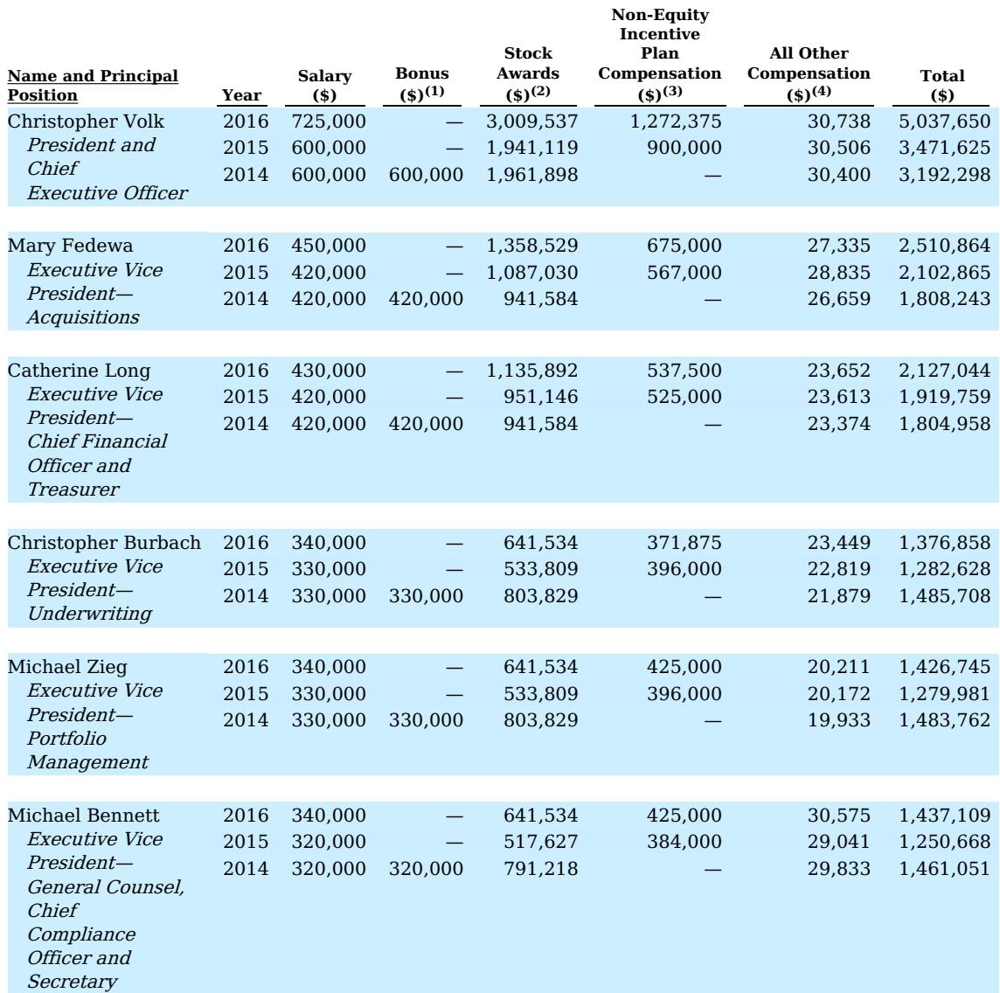

In [ ]:
extracted = await extract_all_summary_compensation(
    found_tables=found,
    all_tables=all_tables,
    client=client,
    model=MODEL,
    base_path=BASE_PATH,
    metadata=meta
)
save_classification_results(found, BASE_PATH / "output" / source_doc, metadata=meta)
save_extraction_results(extracted, BASE_PATH / "output" / source_doc, metadata=meta)
display_all_results(
    extracted_list=extracted,
    found_tables=found,
    metadata=meta,
    base_path=BASE_PATH,
    pil_image_class=PILImage
)